# Subsect Selection Methods (Linear Regression -- Loan Club Dataset)

Most of the time, the studied dataset has a large set of features that may or may not be corrolated to our predicted outcome. Exploratory analysis might be fine for datasets with few features; however, Subset selection methods becomes neccessary for dataset with many features that are hard to explore manually.  

In this notebook, three main subset selection methods are studied; best subset selection, forward stepwise selection, and backward stepwise selection, as well as mixed selection. These methods are not limited to linear regression and can be expanded to other models.  

We use the "loan club" dataset as in previous notebooks. Additional regressors are included (a total of 10 regressors), and the subset that gives the best performance is chosen.

### Load libraries:

In [90]:
import itertools
import pandas as pd
import numpy as np
import copy
import time

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Reset all styles to the default:
plt.rcParams.update(plt.rcParamsDefault)
# Then make graphs inline:
%matplotlib inline

def displaybd(text):
    display(Markdown("**" + text + "**"))

In [3]:
# Set custom style settings:
# NB: We need to separate "matplotlib inline" call and these settings into different
# cells, otherwise the parameters are not set. This is a bug somewhere in Jupyter
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.markersize'] = 10

### Get and Clean the Data

For this notebook, we use a set of 10 regressors to predict our outcome variable. Our model is predicting the total payment from a fully-paid loan (**'total_pymnt':** Payments received to date for total amount funded) based on the following regressors:
- **loan_amnt:** The listed amount of the loan applied for by the borrower.
- **revol_bal:** Total credit revolving balance
- **annual_inc:** The self-reported annual income provided by the borrower during registration.
- **tot_coll_amt:** Total collection amounts ever owed
- **tot_cur_bal:** Total current balance of all accounts

*---The above set of numerical regressors have skewed distribution, so they are nonlinearly transformed to increase the goodness of fit. This nonlinear transformation is also applied to our outcome variable (total_pymnt)*

- **int_rate:** Interest Rate on the loan
- **percent_bc_gt_75:** Percentage of all bankcard accounts > 75% of limit.
- **bc_util:** Ratio of total current balance to high credit/credit limit for all bankcard accounts.

- **term:** The number of payments on the loan. Values are in months and can be either 36 or 60.

*-The 'term' regressor is a binary categorical variable that should be converted to numerical variable during linear regression.*

- **loan_period:** The total period of the loan between the issue date (**issue_d:** The month which the loan was funded) to the last payment date (**last_pymnt_d:** Last month payment was received).  

-*This isn't an orginal feature within the data, we perfom feature engineering to have 'loan_period' regressor which is expected to improve the model goodness of fit.* 


In [147]:
#-- LOAD DATA:

# Load sampled and cleaned loan club dataset
datetime_cols = ['issue_d','last_pymnt_d']
loan_club = pd.read_csv('Loan_sampled_cleaned.csv',parse_dates = datetime_cols)
loan_club_fully_paid = loan_club[loan_club['loan_status']=='Fully Paid'].reset_index(drop=True)
loan_club_fully_paid['loan_period'] = loan_club_fully_paid['last_pymnt_d'] - loan_club_fully_paid['issue_d']
loan_club_fully_paid['loan_period'] = loan_club_fully_paid['loan_period'] / pd.to_timedelta(1, unit='D')
important_cols = ['loan_amnt','term','int_rate','annual_inc','total_pymnt','loan_period',
                  'bc_util','tot_coll_amt','tot_cur_bal','percent_bc_gt_75','revol_bal']

loan_club_fully_paid = loan_club_fully_paid[important_cols]

# Select skewed regressors that should have log transformation. 
colsToLn = list(loan_club_fully_paid.select_dtypes(include=[np.number]).columns)
colsToLn.remove("loan_period")
colsToLn.remove("int_rate")
colsToLn.remove("percent_bc_gt_75")
colsToLn.remove("bc_util")

# Log transform
for colName in colsToLn:
    lnColName = "ln_" + colName
    loan_club_fully_paid[lnColName] = np.log(np.exp(1)+loan_club_fully_paid[colName])
    loan_club_fully_paid.drop([colName], axis=1,inplace = True)

# Convert categorical variables into dummies:
dummies = pd.get_dummies(loan_club_fully_paid[['term']])
X = loan_club_fully_paid.drop(['ln_total_pymnt','term'], axis=1)
cat_features = ['term_ 36 months']

# Extract predictors and outcome variables
X = pd.concat([X, dummies[cat_features]], axis=1).astype('float64')
feature_names = X.columns
y = loan_club_fully_paid.ln_total_pymnt
    
display(X[0:10],y[0:10])

,int_rate,loan_period,bc_util,percent_bc_gt_75,ln_loan_amnt,ln_annual_inc,ln_tot_coll_amt,ln_tot_cur_bal,ln_revol_bal,term_ 36 months
0,14.33,911.0,45.4,50.0,8.854054,11.775311,1.000000,12.345455,7.217970,1.0
1,11.49,577.0,55.4,42.9,10.126740,11.289816,1.000000,12.302218,9.875794,0.0
2,5.32,1066.0,32.9,0.0,8.517737,11.289816,1.000000,12.438278,8.746035,1.0
3,14.31,821.0,33.2,16.7,10.463181,11.813050,1.000000,11.162030,9.428409,1.0
4,13.66,1126.0,101.8,100.0,8.699968,10.645490,5.988255,11.053659,8.790378,1.0
5,11.55,153.0,0.0,0.0,10.126740,12.072557,1.000000,12.921863,7.846480,1.0
6,8.18,519.0,64.7,50.0,9.998921,11.626278,1.000000,10.343892,10.343892,0.0
7,14.49,212.0,0.0,0.0,9.451537,10.534832,5.423708,11.939145,9.477288,1.0
8,16.29,1127.0,64.6,25.0,10.463181,11.849417,8.455258,12.283976,9.073801,1.0
9,10.99,943.0,53.5,20.0,9.433701,10.126740,1.000000,9.353897,9.323108,1.0


0     9.060828
1    10.278455
2     8.598076
3    10.660833
4     8.902444
5    10.170038
6    10.097493
7     9.527945
8    10.702820
9     9.569199
Name: ln_total_pymnt, dtype: float64

## Model Evaluation

To select the best model, we need to decide on a metric to evaluate our model. For linear model, we typically use the $R^2$ metric to evaluate the goodness of fit. However, since we are comparing models of different sizes, we need to use other metrics that are robust to model size. These mertics include Adjusted $R^2$, Bayesian information criterion (BIC), Akaike information criterion (AIC), and Mean squared error (MSE). The following function plots these metrics in one figure. It is expected that the best model would have the lowest BIC, AIK, and MSE and the highest adjusted-$R^2$ value.

In [148]:
# Make plots of the best subset:

def makePlotsForBestSubsets(adjr2s, bics, aics, mses):
    markerSize = 8
    titlesFontSize = 18
    axisLabelFontSize = 16
    
    subsetsNmb = len(adjr2s)
    xvals = range(1, subsetsNmb + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
    plt.subplots_adjust(wspace=0.45, hspace=0.35) 

    ax1.plot(xvals, adjr2s, '-o', markersize=markerSize)
    ax1.set_ylabel('Adjusted R2', fontsize=titlesFontSize)

    ax2.plot(xvals, bics, '-o', markersize=markerSize)
    ax2.set_ylabel('BIC', fontsize=titlesFontSize)

    ax3.plot(xvals, aics, '-o', markersize=markerSize)
    ax3.set_ylabel('AIC', fontsize=titlesFontSize)

    ax4.plot(xvals, mses, '-o', markersize=markerSize)
    ax4.set_ylabel('MSE', fontsize=titlesFontSize)

    for ax in fig.axes:
        ax.set_xlabel('Number of variables', fontsize=titlesFontSize)
        ax.set_xlim(0.5, subsetsNmb + 1)
        ax.set_xticks(range(2, subsetsNmb + 1, 2));
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(axisLabelFontSize) 
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(axisLabelFontSize)

## 1. Best Subset Selection:

The most trivial way to select the best subset of predictors is to fit our model (linear regression) on each possible permutations of the variables for different subset size. This startegy is computionally expensive, but it is guaranteed to find the best subset (the one that optimized a desired metric i.e. MSE). For small number of predictor variables, Best subset selection can work fine, but it grows exponentially with the number of variables ($ 2^n$).

In [185]:
#---- Go through all combinations of features:
def findBestSubsetFixedSize(X, y, subset_size):
    features_nmb = X.shape[1]
    best_subset = []
    best_mse = -1
    for idx_set in itertools.combinations(range(features_nmb), subset_size):
        X_subset = X.iloc[:, list(idx_set)]
        lin_reg = LinearRegression(fit_intercept=True, normalize=False)
        lin_reg.fit(X_subset, y)
        yhat = lin_reg.predict(X_subset)
        mse_resid = mean_squared_error(y, yhat)
        if best_mse < 0 or mse_resid < best_mse:
            best_subset = sorted(list(idx_set))
            best_mse = round(mse_resid,5)
    return([best_subset, best_mse])

def findBestSubset(X, y, max_subset_size):
    best_subsets = [None] * max_subset_size
    best_mses = [None] * max_subset_size
    for subset_size in range(1, max_subset_size + 1):
        best_subsets[subset_size-1], best_mses[subset_size-1] =\
            findBestSubsetFixedSize(X, y, subset_size)

    return([best_subsets, best_mses])

start_time = time.time()
best_subsets, best_mses = findBestSubset(X, y, 10)
best_subset_time = time.time() - start_time
displaybd("Execution Time: --- %s seconds ---" % (best_subset_time))

**Execution Time: --- 7.691387176513672 seconds ---**

**Compared to other subset selection methods, best subset selection approach is relatively long.**

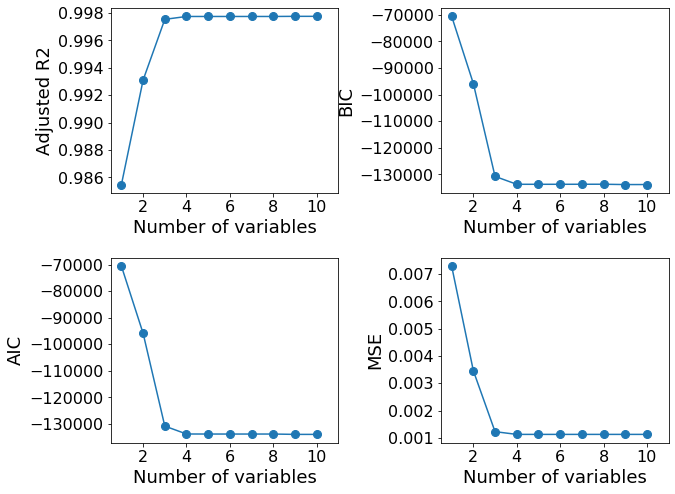

In [186]:
best_adjr2s = [None] * len(best_subsets)
best_bics = [None] * len(best_subsets)
best_aics = [None] * len(best_subsets)
for idx_set in range(len(best_subsets)):
    X_subset = X.iloc[:, best_subsets[idx_set]].values
    X_subset = sm.tools.tools.add_constant(X_subset)
    result = sm.OLS(y, X_subset).fit()
    best_adjr2s[idx_set] = round(result.rsquared_adj,5)
    best_bics[idx_set] = result.bic.astype(int)
    best_aics[idx_set] = result.aic.astype(int)
makePlotsForBestSubsets(best_adjr2s, best_bics, best_aics, best_mses)

A subset of 4 regressors seems to give the best model (lowest MSE). Increasing the number of regressors won't neccessarily damage our model, but it would improve the model accuracy with increased complexity. However, this improvement of goodness of fit might not generalize to test data. A high number of regressors with low corrolation with our outcome variable would be damaging to our model.   

In [187]:
print("Best Regressors: ", list(feature_names[best_subsets[3]]))
print("Adjuster_R2: {} , BIC: {} , AIC: {} , MSE: {}".format(best_adjr2s[3],best_bics[3],best_aics[3],best_mses[3]))

Best Regressors:  ['int_rate', 'loan_period', 'ln_loan_amnt', 'term_ 36 months']
Adjuster_R2: 0.99775 , BIC: -133709 , AIC: -133751 , MSE: 0.00113


**The best subset is made up of the above regressors (ln_loan_amnt, loan_period, int_rate, term). It has a nearly perfect goodness of fit with adjusted_$R^2=0.99775$**

## 2. Forward Stepwise Selection:

This is a smarter way to perform model selection which can work when the number of obesvations (n) is less than the number of regressors (p) ($n < p $). We start with an empty model and then we start adding regressors one by one, where the chosen regressor is the one that optimizes our metric (i.e. minimizes MSE). This method has a linear complexity with the number of regressors, so it would much faster than best subset selection method.

In [184]:
#-- FORWARD Step:
def doFwdSelectStep(X, y, cur_subset):
    features_nmb = X.shape[1]
    new_features = set(range(features_nmb)) - set(cur_subset)

    best_subset = []
    best_mse = -1
    for feature_idx in new_features:
        increased_subset = cur_subset + [feature_idx]
        X_subset = X.iloc[:, increased_subset]
        lin_reg = LinearRegression(fit_intercept=True, normalize=False)
        lin_reg.fit(X_subset, y)
        yhat = lin_reg.predict(X_subset)
        mse_resid = mean_squared_error(y, yhat)
        if best_mse < 0 or mse_resid < best_mse:
            best_subset = sorted(increased_subset)
            best_mse = round(mse_resid,5)
    return([best_subset, best_mse])

#-- FORWARD Loop:
def doFwdStepwiseSelect(X, y, starting_set):
    features_nmb = X.shape[1]
    steps_nmb = features_nmb - len(starting_set)
    best_subsets = [None] * steps_nmb
    best_mses = [None] * steps_nmb
    prev_subset = starting_set
    for step in range(steps_nmb):
        best_subsets[step], best_mses[step] = doFwdSelectStep(X, y, prev_subset)
        prev_subset = best_subsets[step]
    return([best_subsets, best_mses])


start_time = time.time()
best_fwd_subsets, best_fwd_mses = doFwdStepwiseSelect(X, y, [])
best_fwd_time = time.time() - start_time
displaybd("Execution Time: --- %s seconds ---" % (best_fwd_time))

**Execution Time: --- 0.39432692527770996 seconds ---**

**This is much faster than best subset selection method (exponential complexity) given its linear complexity.**

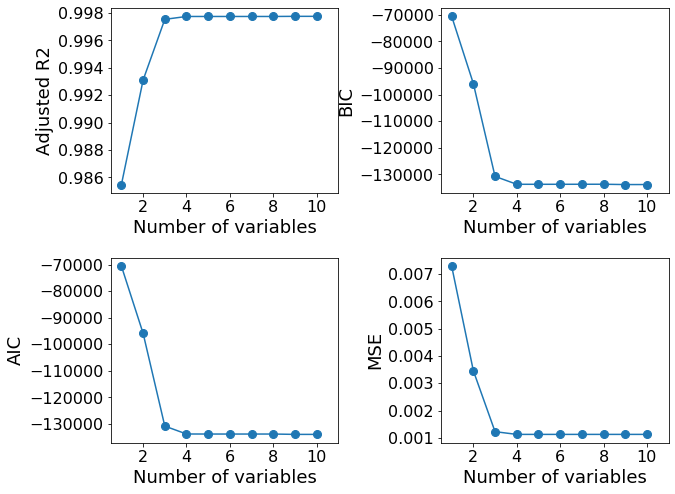

In [188]:
# Make plots for forward subsets:
fwd_sets_nmb = len(best_fwd_subsets)
fwd_adjr2s = [None] * fwd_sets_nmb
fwd_bics = [None] * fwd_sets_nmb
fwd_aics = [None] * fwd_sets_nmb
for idx_set in range(fwd_sets_nmb):
    X_subset = X.iloc[:, best_fwd_subsets[idx_set]].values
    X_subset = sm.tools.tools.add_constant(X_subset)
    result = sm.OLS(y, X_subset).fit()
    fwd_adjr2s[idx_set] = round(result.rsquared_adj,5)
    fwd_bics[idx_set] = result.bic.astype(int)
    fwd_aics[idx_set] = result.aic.astype(int)
    
makePlotsForBestSubsets(fwd_adjr2s, fwd_bics, fwd_aics, best_fwd_mses)

In [163]:
print("Best Regressors: ", list(feature_names[best_fwd_subsets[3]]))
print("Adjuster_R2: {} , BIC: {} , AIC: {} , MSE: {}".format(fwd_adjr2s[3],fwd_bics[3],fwd_aics[3],best_fwd_mses[3]))

Best Regressors:  ['int_rate', 'loan_period', 'ln_loan_amnt', 'term_ 36 months']
Adjuster_R2: 0.99775 , BIC: -133709 , AIC: -133751 , MSE: 0.00113


**Similiar to best subset selection method, a subset of 4 regressors seems to give the best model (lowest MSE).**

## 3. Backward Stepwise Selection

Again, this method has a linear complexity with number of regressors; however, unlike forward stepwise selection, the number of observations need to be greater than the number of regressors ($n > p $). Backward stepwise selection starts with a subset of all possible regressors, and then regressors are eliminated one by one, where the least corrolated regressor is removed. 

In [189]:
#-- BACKWARD Step:
def doBwdSelectStep(X, y, cur_subset):
    if len(cur_subset) == 1:
        return ([],np.mean(y))
    best_subset = []
    best_mse = -1
    for feature_idx in cur_subset:
        reduced_subset = list(set(cur_subset) - {feature_idx})
        X_subset = X.iloc[:, reduced_subset]
        lin_reg = LinearRegression(fit_intercept=True, normalize=False)
        lin_reg.fit(X_subset, y)
        yhat = lin_reg.predict(X_subset)
        mse_resid = mean_squared_error(y, yhat)
        if best_mse < 0 or mse_resid < best_mse:
            best_subset = sorted(reduced_subset)
            best_mse = round(mse_resid,5)
    return([best_subset, best_mse])

#-- BACKWARD Loop:
def doBwdStepwiseSelect(X, y, starting_set):
    steps_nmb = len(starting_set)
    best_subsets = [None] * steps_nmb
    best_mses = [None] * steps_nmb

    X_subset = X.iloc[:, starting_set]
    lin_reg = LinearRegression(fit_intercept=True, normalize=False)
    lin_reg.fit(X_subset, y)
    yhat = lin_reg.predict(X_subset)
    mse_resid = mean_squared_error(y, yhat)

    best_subsets[0] = starting_set
    best_mses[0] = mse_resid

    for step in range(steps_nmb - 1):
        best_subsets[step+1], best_mses[step+1] = doBwdSelectStep(X, y, best_subsets[step])
    return([best_subsets, best_mses])

#-- RUN BACKWARD AND FORWARD STEPWISE SELECTION:
start_time = time.time()
best_bwd_subsets, best_bwd_mses = doBwdStepwiseSelect(X, y, list(range(10)))
best_bwd_time = time.time() - start_time
displaybd("Execution Time: --- %s seconds ---" % (best_bwd_time))

**Execution Time: --- 0.4557499885559082 seconds ---**

**This performance is comparable to forwardstep wise selection, and much faster than best subset selection.**

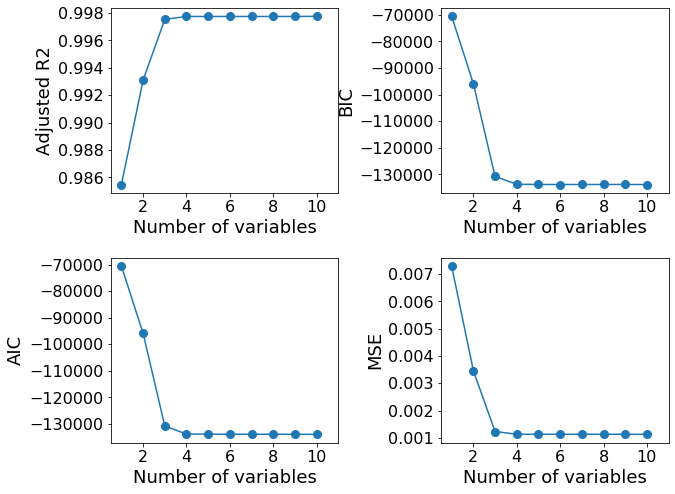

In [156]:
# Reverse the lists:
best_bwd_subsets = best_bwd_subsets[::-1]
best_bwd_mses = best_bwd_mses[::-1]
bwd_sets_nmb = len(best_bwd_subsets)
bwd_adjr2s = [None] * bwd_sets_nmb
bwd_bics = [None] * bwd_sets_nmb
bwd_aics = [None] * bwd_sets_nmb
for idx_set in range(bwd_sets_nmb):
    X_subset = X.iloc[:, best_bwd_subsets[idx_set]].values
    X_subset = sm.tools.tools.add_constant(X_subset)
    result = sm.OLS(y, X_subset).fit()
    bwd_adjr2s[idx_set] = round(result.rsquared_adj,5)
    bwd_bics[idx_set] = result.bic.astype(int)
    bwd_aics[idx_set] = result.aic.astype(int)
    
# Make plots for backward subsets:
makePlotsForBestSubsets(bwd_adjr2s, bwd_bics, bwd_aics, best_bwd_mses)


In [157]:
print("Best Regressors: ", list(feature_names[best_bwd_subsets[3]]))
print("Adjuster_R2: {} , BIC: {} , AIC: {} , MSE: {}".format(bwd_adjr2s[3],bwd_bics[3],bwd_aics[3],best_bwd_mses[3]))

Best Regressors:  ['int_rate', 'loan_period', 'ln_loan_amnt', 'term_ 36 months']
Adjuster_R2: 0.99775 , BIC: -133709 , AIC: -133751 , MSE: 0.00113


**Similiar to the above two methods, a subset of 4 regressors seems to give the best model (lowest MSE).**

## 4. Mixed Subset Selection

It uses both forward and backwark stepwise selection at each step. We start with empty subset (the model is simply the mean of outcome variable), then regressors are added one by one if they improve model performance. At the same time, regressors degrading the perfomance are removed.

In [181]:
def doMixedStepwiseSelect(X, y, starting_set):
    current_subset = starting_set
    yhat = np.mean(y)*np.ones_like(y)
    current_mse = mean_squared_error(y, yhat)

    while True:
        dummy_subset = current_subset.copy()
        fwd_subset, fwd_mse = doFwdSelectStep(X, y, current_subset)
        if fwd_mse < current_mse:
            current_subset = fwd_subset
            current_mse = fwd_mse
        bwd_subset, bwd_mse = doBwdSelectStep(X, y, current_subset)
        if bwd_mse < current_mse:
            current_subset = bwd_subset
            current_mse = bwd_mse
        if dummy_subset == current_subset:
            break
    return current_subset, current_mse

start_time = time.time()
best_mixed_subset, best_mixed_mse = doMixedStepwiseSelect(X, y, [])
best_mixed_time = time.time() - start_time
print("--- %s seconds ---" % (best_mixed_time))
print("Best Regressors: ", list(feature_names[best_mixed_subset]))

--- 0.2702748775482178 seconds ---
Best Regressors:  ['int_rate', 'loan_period', 'ln_loan_amnt', 'term_ 36 months']


**Mixed Selection method is faster than forward and backward selection methods as it needs a fewer iterations. The resulted best subset is the same as for other methods.** 

## 5. Subset Selection Methods Comparison

Here, we compare the different methods in terms of the obtained subset for different sizes and the execution time. 

### Selected Subsets

In [171]:
model_selection = pd.DataFrame(data={'No. Regressors': list(range(1,11)),
                                    'Best Subset' : best_subsets,
                                 'Forward Selection' : best_fwd_subsets,
                                   'Backward Selection' : best_bwd_subsets})

displaybd("model selection:")
model_selection

**model selection:**

,No. Regressors,Best Subset,Forward Selection,Backward Selection
0,1,[4],[4],[4]
1,2,"[1, 4]","[1, 4]","[1, 4]"
2,3,"[0, 1, 4]","[0, 1, 4]","[0, 1, 4]"
3,4,"[0, 1, 4, 9]","[0, 1, 4, 9]","[0, 1, 4, 9]"
4,5,"[0, 1, 4, 8, 9]","[0, 1, 4, 8, 9]","[0, 1, 2, 4, 9]"
5,6,"[0, 1, 4, 7, 8, 9]","[0, 1, 4, 7, 8, 9]","[0, 1, 2, 3, 4, 9]"
6,7,"[0, 1, 4, 6, 7, 8, 9]","[0, 1, 4, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 9]"
7,8,"[0, 1, 4, 5, 6, 7, 8, 9]","[0, 1, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 9]"
8,9,"[0, 1, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 9]"
9,10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"


**As expected, the solutions are almost the same. Best subset method gives exactly same result as forward stepwise selection. For subset size greater than 4, backward stepwise selection has a slightly different model since the quality of these larger subsets is almost the same.**

### Execution Time

We compare the different methods performance through the mean and the standard deviation of the execution time. 

In [182]:
best_subset_times = []
best_fwd_times = []
best_bwd_times = []
best_mixed_times = []

#Collect 30 samples
for i in range(30):
    start_time = time.time()
    _ , _ = findBestSubset(X, y, 10)
    best_subset_time = time.time() - start_time
    best_subset_times.append(best_subset_time)
    
    start_time = time.time()
    _ , _ = doFwdStepwiseSelect(X, y, [])
    best_fwd_time = time.time() - start_time
    best_fwd_times.append(best_fwd_time)
    
    start_time = time.time()
    _ , _ = doBwdStepwiseSelect(X, y, list(range(10)))
    best_bwd_time = time.time() - start_time
    best_bwd_times.append(best_bwd_time)
    
    start_time = time.time()
    best_mixed_subset, best_mixed_mse = doMixedStepwiseSelect(X, y, [])
    best_mixed_time = time.time() - start_time
    best_mixed_times.append(best_mixed_time)
    
execution_time = pd.DataFrame(data={'Best Subset' : [np.mean(best_subset_times),np.std(best_subset_times)],
                                 'Forward Selection' : [np.mean(best_fwd_times),np.std(best_fwd_times)],
                                   'Backward Selection' : [np.mean(best_bwd_times),np.std(best_bwd_times)],
                                   'Mixed Selection' : [np.mean(best_mixed_times),np.std(best_mixed_times)]},
                              index = ['Mean ','Standard Deviation'])

displaybd("Execution Time Comparison:")
execution_time

**Execution Time Comparison:**

,Best Subset,Forward Selection,Backward Selection,Mixed Selection
Mean,9.410548,0.416183,0.549309,0.304677
Standard Deviation,0.733783,0.061786,0.063896,0.049416


- **Due to the thorough search of the best subset method (exponential time), it takes the longest time of all.**  


- **Forward and backward stepwise selection have comparable performance; however, forward selection has a faster perfomance. Although both methods fit the same number of models, forward stepwise selection fits $p$ models of size one and 2 models of size $p-1$. On the other hand, backward stepwise selection fits $p$ models of size $p-1$ and 2 models of size two.**  


- **Mixed selection method is linear; however it stops when there is no improvement in the model. Thus, it takes fewer steps and shorter execution time.**

### Fit the best model

In [161]:
yColName = 'ln_total_pymnt'

olsFormula = 'ln_total_pymnt~ln_loan_amnt+loan_period+int_rate+term'

model = sm.OLS.from_formula(olsFormula, data=loan_club_fully_paid)
res = model.fit(cov_type='HC0')

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_total_pymnt   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.256e+06
Date:                Sun, 14 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:49:49   Log-Likelihood:                 66881.
No. Observations:               33887   AIC:                        -1.338e+05
Df Residuals:                   33882   BIC:                        -1.337e+05
Df Model:                           4                                         
Covariance Type:                  HC0                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0862      0.003    -33.053      0.000      -0.091      -0.081
term[T. 60 months]     0.0293      0.001     51.473      0.000       0.028       0.030
ln_loan_amnt           0.9992      0.000   3869.769      0.000       0.999       1.000
loan_period            0.0002   5.92e-07    285.396      0.000       0.000       0.000
int_rate               0.0093   6.83e-05    135.541      0.000       0.009       0.009
==============================================================================
Omnibus:                     6252.507   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23729.012
Skew:                          -0.891   Prob(JB):                         0.00
Kurtosis:                       6.692   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**All the chosen regressors are significant; however, ln_loan_amnt has the greatest influence on the outcome.**